In [1]:
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas
import pathlib

# Accuracies

In [2]:
!ls *.npy

lava_accuracy_noDelay_bias_zero.npy
lava_activity_noDelay_bias_zero.npy
norse_accuracy_noDelay_bias_zero.npy
norse_accuracy_noDelay_noBias_subtract.npy
norse_activity_noDelay_bias_zero.npy
norse_activity_noDelay_noBias_subtract.npy
rockpool_accuracy_noDelay_noBias_subtract.npy
rockpool_activity_noDelay_noBias_subtract.npy
s2_accuracy_noDelay_bias_zero.npy
s2_accuracy_noDelay_noBias_subtract.npy
s2_activity_noDelay_bias_zero.npy
s2_activity_noDelay_noBias_subtract.npy
snntorch_accuracy_noDelay_bias_zero.npy
snntorch_accuracy_noDelay_noBias_subtract.npy
snntorch_activity_noDelay_bias_zero.npy
snntorch_activity_noDelay_noBias_subtract.npy
spyx_accuracy_noDelay_bias_zero.npy
spyx_accuracy_noDelay_noBias_subtract.npy
spyx_activity_noDelay_bias_zero.npy
spyx_activity_noDelay_noBias_subtract.npy
xylo_accuracy_noDelay_noBias_subtract.npy
xylo_activity_noDelay_noBias_subtract.npy


In [3]:
def read_framework(framework, part):
    sub = None
    zero = None
    for f in pathlib.Path().glob(f"{framework.lower()}_*{part}*_subtract.npy"):
        sub = np.load(str(f))
    for f in pathlib.Path().glob(f"{framework.lower()}_*{part}*_zero.npy"):
        zero = np.load(str(f))
    return sub, zero
read_framework("norse", "activity")[0].shape

(256, 40)

In [4]:
frameworks = [
    "Lava",
    "Norse",
    "Rockpool",
    "snnTorch",
    "S2",
    "Spyx",
    "Xylo"
]

In [5]:
acc = [read_framework(x, "accuracy") for x in frameworks]
acc_sub = np.stack([x[0] for x in acc])
acc_zero = np.stack([x[1] for x in acc])

In [6]:
list(zip(acc_sub, frameworks))

[(None, 'Lava'),
 (93.57, 'Norse'),
 (0.7142857142857143, 'Rockpool'),
 (0.9214285714285714, 'snnTorch'),
 (93.57, 'S2'),
 (0.9214285612106323, 'Spyx'),
 (0.8571428571428571, 'Xylo')]

In [7]:
list(zip(acc_zero, frameworks))

[(0.4857142857142857, 'Lava'),
 (94.29, 'Norse'),
 (None, 'Rockpool'),
 (0.95, 'snnTorch'),
 (85.0, 'S2'),
 (0.8428571224212646, 'Spyx'),
 (None, 'Xylo')]

# Activities

In [8]:
act = [read_framework(x, "activity") for x in frameworks]
named_frameworks = [x.replace("S2", "SpiNNaker2") for x in frameworks]

act_sub = []
act_zero = []
for name, (sub, zero) in zip(named_frameworks, act):
    if sub is not None:
        act_sub.append((name, sub))
    if zero is not None:
        if name == "Lava":
            zero = zero.T
        act_zero.append((name, zero))

In [9]:
def calculate_similarities(activities):
    metric = torch.nn.CosineSimilarity(0)
    names = [x[0] for x in activities]
    divs = pandas.DataFrame(index=names)
    dics = divs.iloc[divs.index.str.lower().argsort()]
    for name, activity in activities:
      act_row = []
      for name2, activity2 in activities:
        a1 = torch.tensor(activity).float().mean(0).flatten(0)
        a2 = torch.tensor(activity2).float().mean(0).flatten(0) 
        dist = metric(a1, a2)
        act_row.append(dist.item())
      divs[name] = act_row
    return divs

calculate_similarities(act_zero)

,Lava,Norse,snnTorch,SpiNNaker2,Spyx
Lava,1.000000,0.844371,0.800490,0.850551,0.753119
Norse,0.844371,1.000000,0.522990,0.595668,0.466764
snnTorch,0.800490,0.522990,1.000000,0.966844,0.990627
SpiNNaker2,0.850551,0.595668,0.966844,1.000000,0.964495
Spyx,0.753119,0.466764,0.990627,0.964495,1.000000


In [10]:
import torch

d = torch.load("data/ds_test.pt")[0][0]

In [11]:
torch.load("data/ds_test.pt")[0][1]

tensor(1)

In [12]:
np.flip(1 - np.triu(np.ones((5, 5))))

array([[0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]])

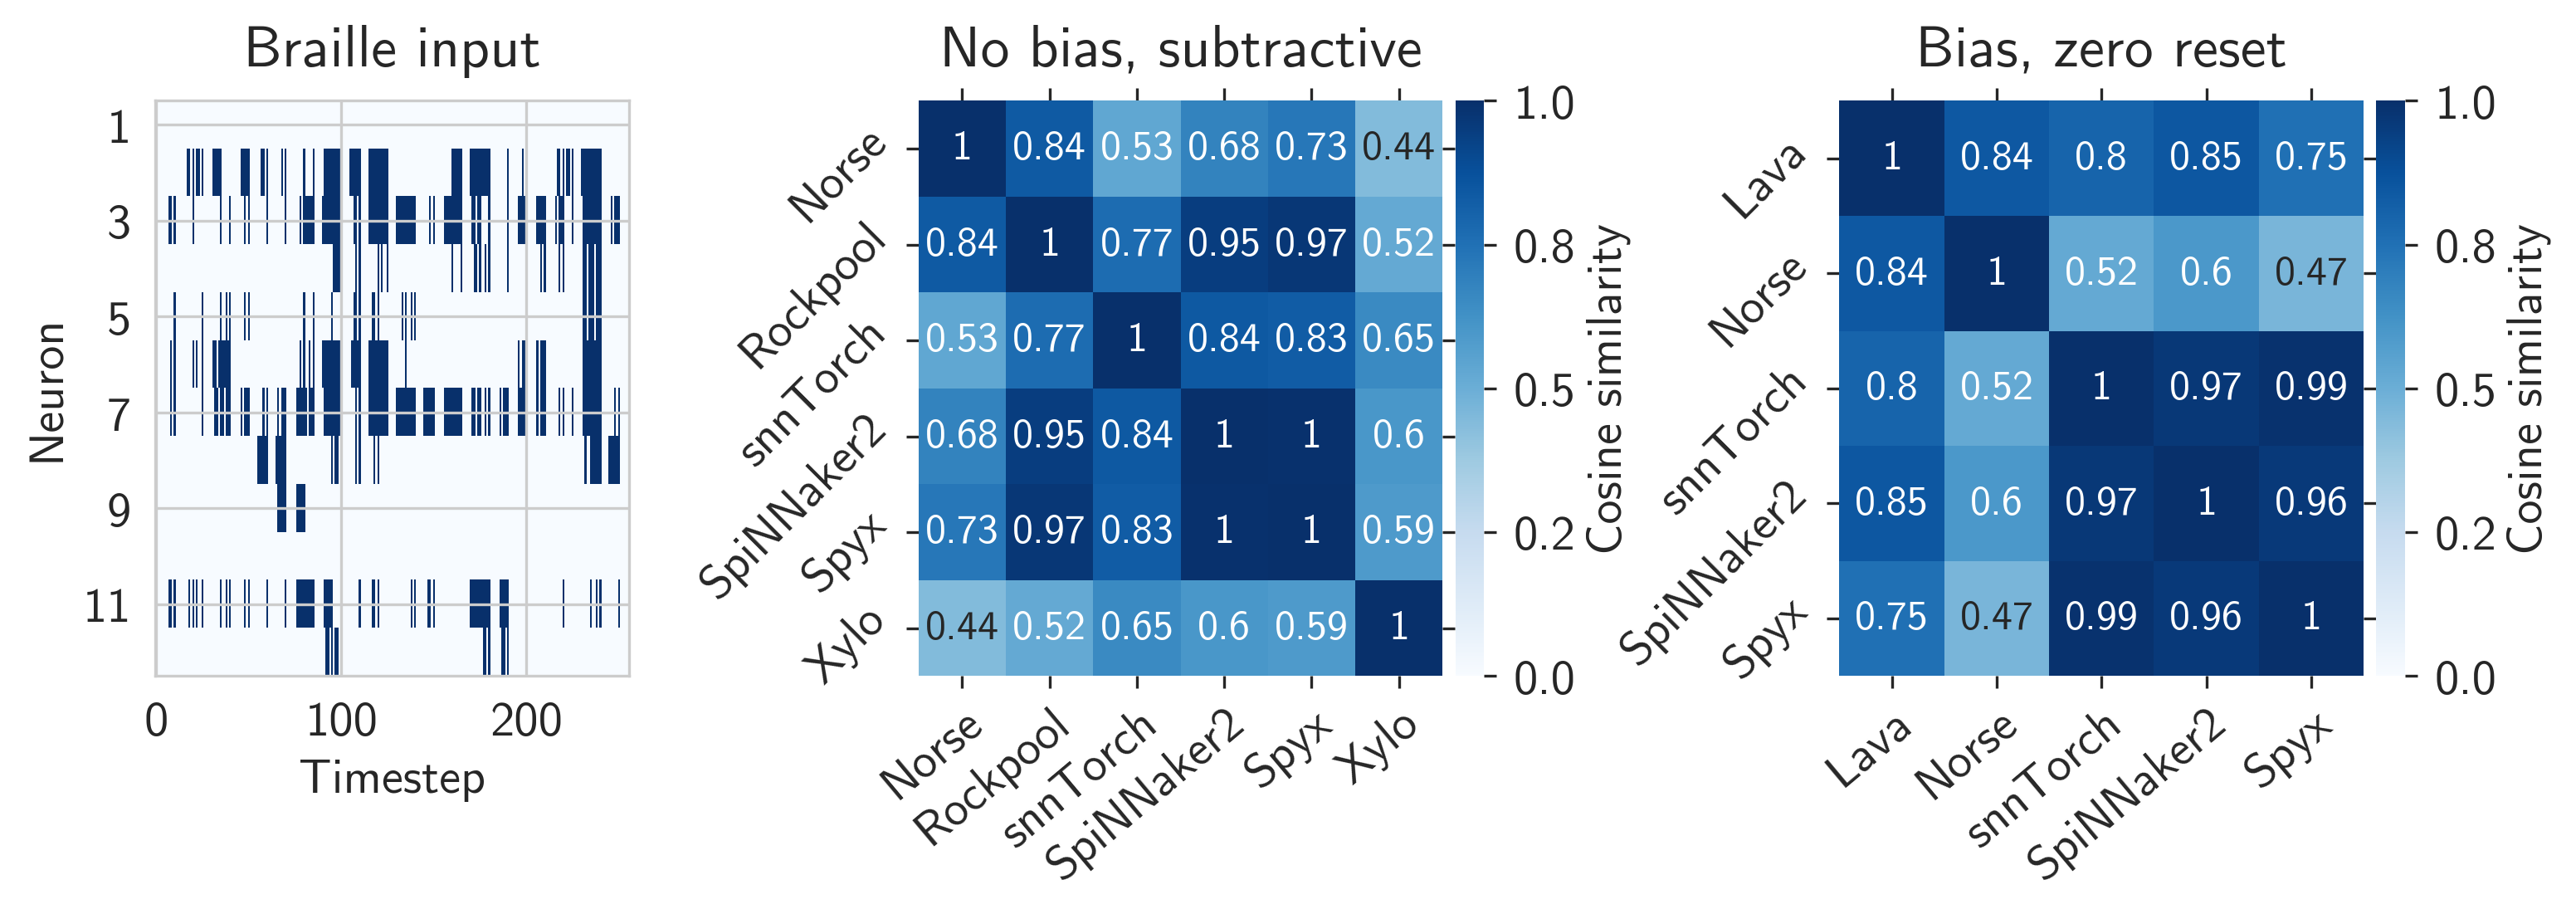

In [26]:
# plt.style.use("../plots.mplstyle")
# seaborn.set_context("paper", font_scale=1)
seaborn.set_style("whitegrid")
font = {'family' : 'CMU Sans Serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

def plot_similarities(activities, ax):
    divs = calculate_similarities(activities)
    # mask = np.flip(1 - np.triu(divs)).astype(np.int8)
    seaborn.heatmap(divs.abs(), ax=ax, cmap="Blues", cbar_kws={"pad": 0.02}, annot=True, vmin=0, annot_kws={"fontsize": 12})

f, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 3), dpi=300, width_ratios=[0.3, 0.4, 0.4], gridspec_kw={"wspace": 0.5})
plot_similarities(act_sub, a1)
plot_similarities(act_zero, a2)

a0.set_title("Braille input", pad=10)
a1.set_title("No bias, subtractive", pad=10)
a2.set_title("Bias, zero reset", pad=10)

a0.imshow(d.T, cmap="Blues", aspect="auto", interpolation="none")
a0.set_xlabel("Timestep")
a0.set_ylabel("Neuron")
a0.set_yticks(range(0, 12, 2), range(1, 13, 2))

for a in [a1, a2]:
    a.collections[0].colorbar.set_label("Cosine similarity", labelpad=3)
    a.collections[0].colorbar.ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))
    a.collections[0].colorbar.ax.tick_params(pad=5)
    a.xaxis.set_ticks_position("both")
    plt.setp(a.get_xticklabels(), rotation=40, va="top", ha="right", rotation_mode="anchor")
    a.yaxis.set_ticks_position("both")
    plt.setp(a.get_yticklabels(), rotation=45, va="bottom", ha="right", rotation_mode="anchor")

f.savefig("../figures/rnn_similarity.pdf", bbox_inches="tight")